In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

C:\Users\nikit\AppData\Local\Temp\ipykernel_9364\4080024128.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_monthly = ts.resample('M').sum()


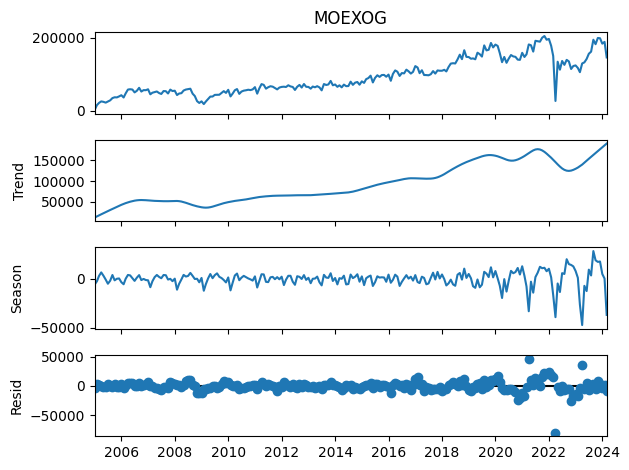

In [58]:
data = pd.read_csv('./data/data_indexes_moex.csv', index_col=0)
data.index = pd.to_datetime(data.index)

ts = data['MOEXOG'].interpolate(method='time')

# Преобразование ежедневных данных в месячные, используя значение за месяц
ts_monthly = ts.resample('M').sum()

decompose = STL(ts_monthly)
result = decompose.fit()

# Получим компоненты ряда
trend = result.trend
seasonal = result.seasonal
residual = result.resid

result.plot()
plt.show()

In [81]:
# Модель прогнозирования тренда (линейная регрессия)
trend_model = LinearRegression()
trend_model.fit(np.arange(len(trend)).reshape(-1, 1), trend)

# Модель прогнозирования сезонности (SARIMA)
seasonal_model = SARIMAX(seasonal, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
seasonal_model_fit = seasonal_model.fit()

# Модель прогнозирования остатков (градиентный бустинг)
residual_model = GradientBoostingRegressor()
residual_model.fit(np.arange(len(residual)).reshape(-1, 1), residual)

# Прогнозирование тренда
trend_forecast = trend_model.predict(np.arange(len(trend), len(trend) + len(ts_monthly)).reshape(-1, 1))

# Прогнозирование сезонности
seasonal_forecast = seasonal_model_fit.predict(len(seasonal), len(seasonal) + len(ts_monthly) - 1)

# Прогнозирование остатков
residual_forecast = residual_model.predict(np.arange(len(residual), len(residual) + len(ts_monthly)).reshape(-1, 1))

# Общий прогноз
total_forecast = trend_forecast + seasonal_forecast + residual_forecast

# Оценка производительности моделей с помощью кросс-валидации временных рядов
cv = TimeSeriesSplit(n_splits=10)

# Списки для хранения значений MSE и моделей
best_trend_mse = float('inf')
best_seasonal_mse = float('inf')
best_residual_mse = float('inf')

for train_index, test_index in cv.split(ts_monthly):
    trend_train, trend_test = trend[train_index], trend[test_index]
    seasonal_train, seasonal_test = seasonal[train_index], seasonal[test_index]
    residual_train, residual_test = residual[train_index], residual[test_index]
    
    # Обучение модели тренда на обучающих данных
    trend_model.fit(np.arange(len(trend_train)).reshape(-1, 1), trend_train)
    
    # Прогнозирование тренда на тестовых данных
    trend_predicted = trend_model.predict(np.arange(len(trend_train), len(trend_train) + len(trend_test)).reshape(-1, 1))
    
    # Расчет MSE для модели тренда
    trend_mse = mean_squared_error(trend_test, trend_predicted)
    if trend_mse < best_trend_mse:
        best_trend_mse = trend_mse
    
    # Прогнозирование остатков на тестовых данных
    residual_model.fit(np.arange(len(residual_train)).reshape(-1, 1), residual_train)
    residual_predicted = residual_model.predict(np.arange(len(residual_train), len(residual_train) + len(residual_test)).reshape(-1, 1))
    
    # Расчет MSE для модели остатков
    residual_mse = mean_squared_error(residual_test, residual_predicted)
    if residual_mse < best_residual_mse:
        best_residual_mse = residual_mse

    # Прогнозирование сезонности на тестовых данных
    seasonal_predicted = seasonal_model_fit.predict(start=len(seasonal_train), end=len(seasonal_train) + len(seasonal_test) - 1)
    
    # Расчет MSE для модели сезонности
    seasonal_mse = mean_squared_error(seasonal_test, seasonal_predicted)
    if seasonal_mse < best_seasonal_mse:
        best_seasonal_mse = seasonal_mse

# Вывод лучших значений MSE для каждой модели
print("MSE для модели тренда (линейная регрессия):", best_trend_mse)
print("MSE для модели сезонности (SARIMA):", best_seasonal_mse)
print("MSE для модели остатков (градиентный бустинг):", best_residual_mse)

C:\Users\nikit\AppData\Local\Temp\ipykernel_9364\1358549543.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  trend_train, trend_test = trend[train_index], trend[test_index]
C:\Users\nikit\AppData\Local\Temp\ipykernel_9364\1358549543.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seasonal_train, seasonal_test = seasonal[train_index], seasonal[test_index]
C:\Users\nikit\AppData\Local\Temp\ipykernel_9364\1358549543.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access 

MSE для модели тренда (линейная регрессия): 4537960.886849435
MSE для модели сезонности (SARIMA): 776495.6657105652
MSE для модели остатков (градиентный бустинг): 7938527.030170157


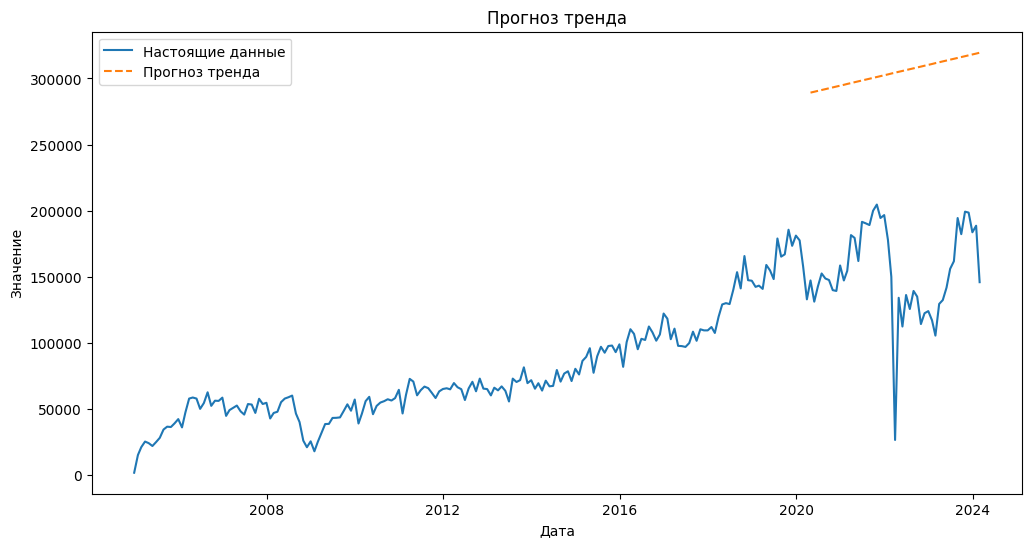

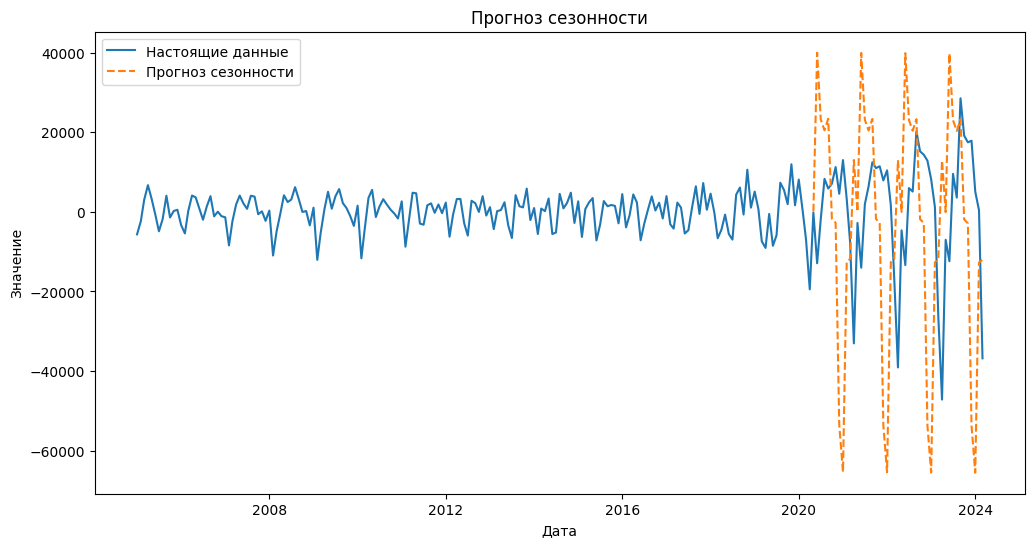

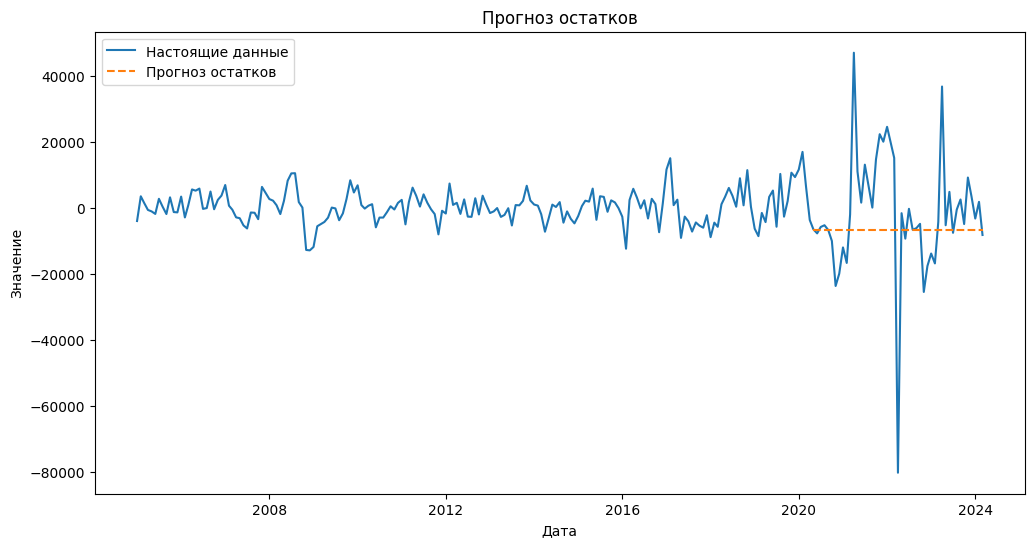

In [82]:
eighty_percent_index = int(0.8 * len(ts_monthly.index))

# Построение графика прогноза и настоящих данных для тренда
plt.figure(figsize=(12, 6))
plt.plot(ts_monthly.index, ts_monthly, label='Настоящие данные')
plt.plot(ts_monthly.index[eighty_percent_index:], trend_forecast[eighty_percent_index:], label='Прогноз тренда', linestyle='--')
plt.title('Прогноз тренда')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

# Построение графика прогноза и настоящих данных для сезонности
plt.figure(figsize=(12, 6))
plt.plot(ts_monthly.index, seasonal, label='Настоящие данные')
plt.plot(ts_monthly.index[eighty_percent_index:], seasonal_forecast[eighty_percent_index:], label='Прогноз сезонности', linestyle='--')
plt.title('Прогноз сезонности')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

# Построение графика прогноза и настоящих данных для остатков
plt.figure(figsize=(12, 6))
plt.plot(ts_monthly.index, residual, label='Настоящие данные')
plt.plot(ts_monthly.index[eighty_percent_index:], residual_forecast[eighty_percent_index:], label='Прогноз остатков', linestyle='--')
plt.title('Прогноз остатков')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()